###Importações

In [61]:
# Importações básicas
import os

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Importação do Dataset - Google Drive
from google.colab import files

In [62]:
# Balanceamento de classes
# Conforme indicado no notebook de tratamento de dados,
# o balanceamento ainda não foi feito
from imblearn.over_sampling import SMOTE

# Divisão do dataset - criação do conjunto de validação
from sklearn.model_selection import train_test_split

In [63]:
# Importação de modelagem
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier

In [64]:
# Importação de métricas
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    recall_score,
    ConfusionMatrixDisplay,
    fbeta_score,
    roc_auc_score,
    roc_curve,
    RocCurveDisplay,
    )
from sklearn.preprocessing import LabelBinarizer

In [65]:
# Importação das curvas
from sklearn.preprocessing import LabelBinarizer

# Importação para determinar as principais features
from sklearn.inspection import permutation_importance

In [66]:
# Carregamento do Dataset de treino
if not os.path.exists('fetal_health_train_multi.csv'):
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename != 'fetal_health_train_multi.csv':

            os.rename(
                filename,
                'fetal_health_train_multi.csv'
                )

df_train = pd.read_csv('fetal_health_train_multi.csv')

In [67]:
# Carregamento do Dataset de teste
if not os.path.exists('fetal_health_test_multi.csv'):
    uploaded = files.upload()

    for filename in uploaded.keys():
        if filename != 'fetal_health_test_multi.csv':

            os.rename(
                filename,
                'fetal_health_test_multi.csv'
                )

df_test = pd.read_csv('fetal_health_test_multi.csv')

In [68]:
# Divisão dos dados
# de treino
X_train = df_train.drop('fetal_health', axis=1)
y_train = df_train['fetal_health']

# de teste
X_test = df_test.drop('fetal_health', axis=1)
y_test = df_test['fetal_health']

###Balanceamento

In [69]:
# Por SMOTE
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

In [70]:
# Quantidade de amostras
# A ideia era conduzir a modelagem usando 70% x 30%,
# mas, como o SMOTE foi aplicado depois da separação para não comprometer o conjunto de teste
# a proporção favoreceu o conjunto de treino
print(f"Conjunto de treino: {len(X_train)} amostras.")
print(f"Conjunto de teste: {len(X_test)} amostras.")

Conjunto de treino: 3456 amostras.
Conjunto de teste: 634 amostras.


O dataset originalmente é separado em 3 (três) classes (normal, suspeito e patológico), porém foi dada a ideia de tornar o problema binário, já que o propósito do projeto é a explicabilidade e aplicação de técnicas, não necessariamente o seguimento fiel do dataset. Logo, neste notebook, foram criados 2 (dois) modelos: um multiclasse e um binário.

###Modelo multiclasse

In [71]:
# Construção e Treinamento da MLP
print("\nConfigurando e treinando a MLP...")

# Configuração da MLP
mlp_multi = MLPClassifier(
    # Básicos
    hidden_layer_sizes=(8,10,12,13),
    activation='relu',
    solver='adam',
    learning_rate_init=0.001,
    max_iter=120,

    # Outros
    alpha=0.001,
    batch_size=64,
    n_iter_no_change=25,
    tol=1e-5,

    random_state=42,
    )

print("Arquitetura da MLP:", mlp_multi.hidden_layer_sizes)
print("Função de Ativação:", mlp_multi.activation)
print("Otimizador:", mlp_multi.solver)
print("Taxa de Aprendizado:", mlp_multi.learning_rate_init)
print("Número máximo de épocas:", mlp_multi.max_iter)
print("Alpha:", mlp_multi.alpha)


Configurando e treinando a MLP...
Arquitetura da MLP: (8, 10, 12, 13)
Função de Ativação: relu
Otimizador: adam
Taxa de Aprendizado: 0.001
Número máximo de épocas: 120
Alpha: 0.001


Todos os parâmetros personalizados desse modelo foram testados manualmente. Outros recursos como a tunagem (Grid Search ) com a importação de biblioteca e a validação cruzada foram empregadas experimentalmente, mas os resultados foram insatisfatórios e piores do que os obtidos manualmente.

Resumindo, os parâmetros definidos foram testados e ajustados ao comparar com um conjunto de validação (usado e removido, mantendo apenas os parâmetros utilizados).

In [72]:
# Treinar a MLP
mlp_multi.fit(X_train, y_train)
print("Treinamento concluído.")

Treinamento concluído.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(


Avaliação do modelo

In [73]:
# Avaliação do Modelo
print("\nAvaliando a MLP...")

# Fazer previsões no conjunto de teste
y_pred = mlp_multi.predict(X_test)
y_prob = mlp_multi.predict_proba(X_test)


Avaliando a MLP...


In [74]:
# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Calculando o recall
recall_risco = recall_score(y_test, y_pred, average='macro')
print(f"Recall: {recall_risco:.4f}")

# Calculando o f2 (recall relacionado à precisão)
f2 = fbeta_score(y_test, y_pred, beta=2, average='macro')
print(f"F2 Score: {f2:.4f}")

Acurácia no conjunto de teste: 0.8770
Recall: 0.8481
F2 Score: 0.8264


In [75]:
# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


Relatório de Classificação:
              precision    recall  f1-score   support

         1.0       0.98      0.89      0.93       494
         2.0       0.56      0.78      0.65        88
         3.0       0.76      0.87      0.81        52

    accuracy                           0.88       634
   macro avg       0.77      0.85      0.80       634
weighted avg       0.90      0.88      0.89       634




Matriz de Confusão:


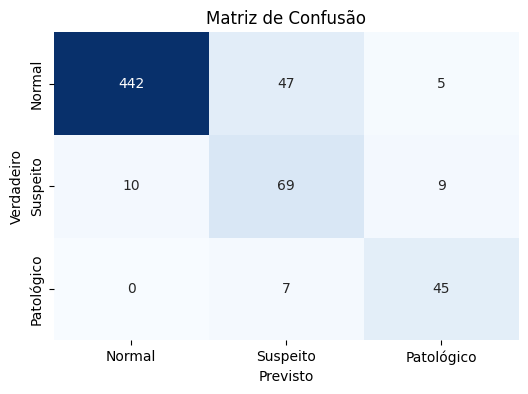

In [76]:
# Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))

sns.heatmap(
    cm,
    annot=True,
    fmt='d',
    cmap='Blues',
    cbar=False,
    xticklabels=['Normal', 'Suspeito', 'Patológico'],
    yticklabels=['Normal', 'Suspeito', 'Patológico'],
    )

plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

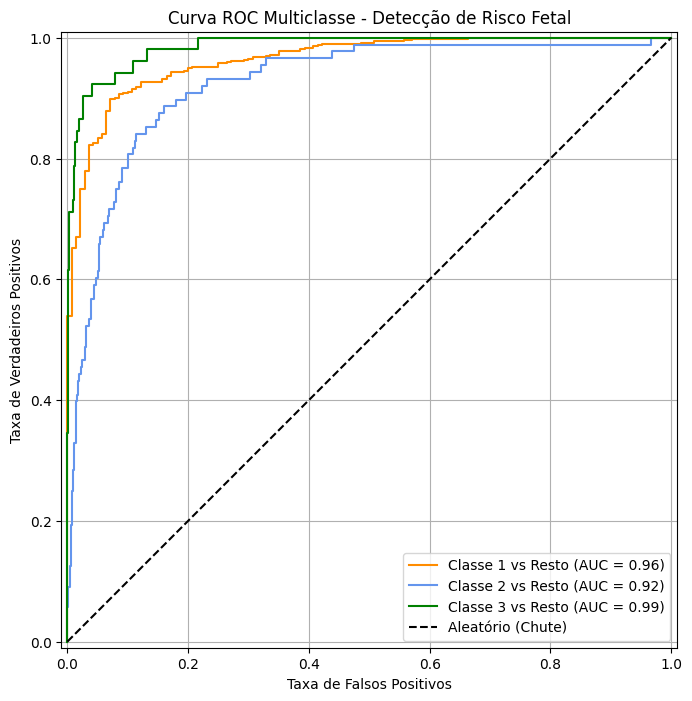

In [77]:
# Avaliação Roc
classes = [1, 2, 3]
lb = LabelBinarizer()
lb.fit(classes)
y_test_bin = lb.transform(y_test)

fig, ax = plt.subplots(figsize=(10, 8))

colors = ["darkorange", "cornflowerblue", "green"]

for i, class_label in enumerate(classes):
    RocCurveDisplay.from_predictions(
        y_test_bin[:, i],
        y_prob[:, i],
        name=f"Classe {class_label} vs Resto",
        color=colors[i],
        ax=ax,
        )

plt.plot([0, 1], [0, 1], "k--", label="Aleatório (Chute)")
plt.title("Curva ROC Multiclasse - Detecção de Risco Fetal")
plt.xlabel("Taxa de Falsos Positivos")
plt.ylabel("Taxa de Verdadeiros Positivos")
plt.legend()
plt.grid(True)
plt.show()

Os valores resultantes, apesar de não serem ideais na área médica, evidenciam que o modelo se distancia do "chute" (combatendo a ingenuidade). Além disso, o caso mais crítico que poderia acontecer foi excluído da questão: um caso patológico ser erroneamente classificado como normal. Desta forma, é visível o bom desempenho do modelo em diferenciar casos patológicos de normais (matriz de confusão) e os altos valores de AUC, consegue separar classificações de forma excelente. Por outro lado, o f2-score (uma das métricas definidas como mais importantes no projeto) é de desempenho abaixo do esperado, com apenas 82,64%.

/tmp/ipython-input-88117857.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])


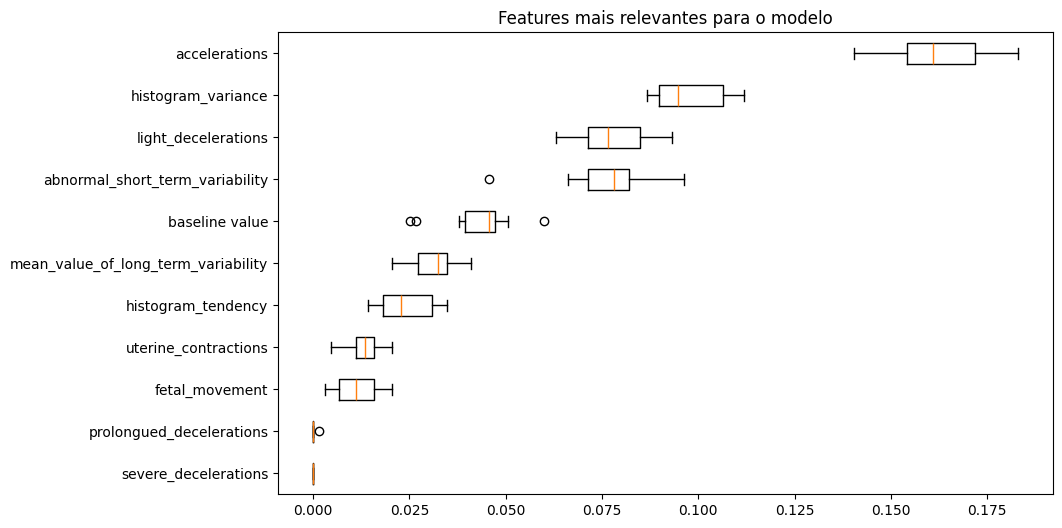

In [78]:
# Boxplot das features mais importantes
result = permutation_importance(
    mlp_multi,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    )

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Features mais relevantes para o modelo")
plt.show()

Embora as features "severe_decelerations" e "prolongued_decelerations", no boxplot, apresentem menor relevância na escolha classificação pelo modelo, ao serem retiradas, diminuem o valor do recall das classes minoritárias. Isso justifica a permanência delas.

###Modelo binário

In [79]:
# Conversão do modelo em binário
# No conjunto de treino
y_train = df_train['fetal_health']
y_train = y_train.replace(3, 2)
df_train['fetal_health'] = y_train

# No conjunto de teste
y_test = df_test['fetal_health']
y_test = y_test.replace(3, 2)
df_test['fetal_health'] = y_test

# Resetando valores de X
X_train = df_train.drop('fetal_health', axis=1)
X_test = df_test.drop('fetal_health', axis=1)

In [80]:
# Construção e Treinamento da MLP
print("\nConfigurando e treinando a MLP...")

# Configuração da MLP
mlp_bin = MLPClassifier(
    # Básicos
    hidden_layer_sizes=(8,10,12,),
    activation='relu',
    solver='adam',
    learning_rate_init=0.01,
    max_iter=120,

    # Outros
    alpha=0.001,
    batch_size=64,
    n_iter_no_change=20,
    tol=1e-7,

    random_state=42,
    )

print("Arquitetura da MLP:", mlp_bin.hidden_layer_sizes)
print("Função de Ativação:", mlp_bin.activation)
print("Otimizador:", mlp_bin.solver)
print("Taxa de Aprendizado:", mlp_bin.learning_rate_init)
print("Número máximo de épocas:", mlp_bin.max_iter)
print("Alpha:", mlp_bin.alpha)


Configurando e treinando a MLP...
Arquitetura da MLP: (8, 10, 12)
Função de Ativação: relu
Otimizador: adam
Taxa de Aprendizado: 0.01
Número máximo de épocas: 120
Alpha: 0.001


Novamente, os parâmetros personalizados foram definidos com ajuste manual, uma vez que outras ferramentas de pesquisa e de validação obtiveram resultados insuficiêntes.

In [81]:
# Treinar a MLP
mlp_bin.fit(X_train, y_train)
print("Treinamento concluído.")

Treinamento concluído.


/usr/local/lib/python3.12/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (120) reached and the optimization hasn't converged yet.
  warnings.warn(


Avaliação do modelo

In [82]:
# Avaliação do Modelo
print("\nAvaliando a MLP...")

# Fazer previsões no conjunto de teste
y_pred = mlp_bin.predict(X_test)


Avaliando a MLP...


In [83]:
# Calculando a acurácia
accuracy = accuracy_score(y_test, y_pred)
print(f"Acurácia no conjunto de teste: {accuracy:.4f}")

# Calculando o recall
recall_risco = recall_score(y_test, y_pred, pos_label=1)
print(f"Recall: {recall_risco:.4f}")

# Calculando o f2 (recall relacionado à precisão)
f2 = fbeta_score(y_test, y_pred, beta=2, average='macro')
print(f"F2 Score: {f2:.4f}")

# Calculando o AUC-ROC Score
auc_score = roc_auc_score(y_test, y_pred)
print(f"AUC-ROC Score: {auc_score:.4f}")

Acurácia no conjunto de teste: 0.9180
Recall: 0.9777
F2 Score: 0.8524
AUC-ROC Score: 0.8424


Diferente do modelo de multiclasse, o binário apresenta melhores parâmetros de acurácia, recall e F2-score, uma evolução siginificativa. Todavia, o AUC-ROC diminuiu para 84,24%, isso ocorre devido à junção dos casos suspeitos aos patológicos, que, embora semelhantes, ainda assim têm características específicas. Isso dificulta a distinção correta das classes.

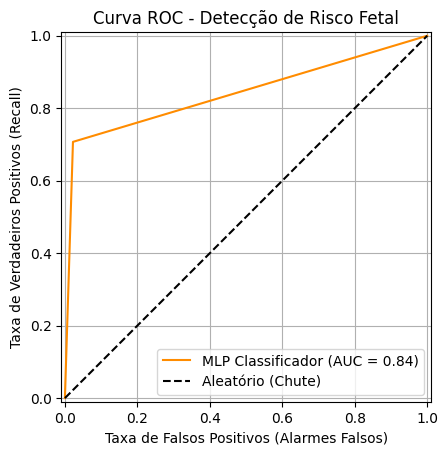

In [84]:
# Plot da curva do AUC-ROC Score
RocCurveDisplay.from_predictions(
    y_test,
    y_pred,
    name="MLP Classificador",
    pos_label=2,    # Dizendo que a classe '2' é o nosso alvo (Risco)
    color="darkorange",
    )

# Estética do gráfico
plt.plot([0, 1], [0, 1], "k--", label="Aleatório (Chute)") # Linha pontilhada de referência
plt.title("Curva ROC - Detecção de Risco Fetal")
plt.xlabel("Taxa de Falsos Positivos (Alarmes Falsos)")
plt.ylabel("Taxa de Verdadeiros Positivos (Recall)")
plt.legend()
plt.grid(True)
plt.show()

In [85]:
# Relatório de Classificação
print("\nRelatório de Classificação:")
print(classification_report(y_test, y_pred))


Relatório de Classificação:
              precision    recall  f1-score   support

         1.0       0.92      0.98      0.95       494
         2.0       0.90      0.71      0.79       140

    accuracy                           0.92       634
   macro avg       0.91      0.84      0.87       634
weighted avg       0.92      0.92      0.91       634




Matriz de Confusão:


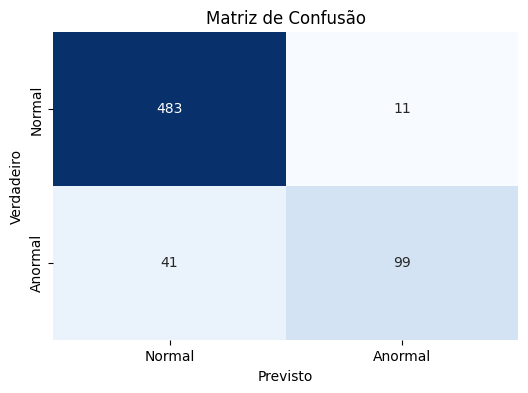

In [86]:
# Matriz de Confusão
print("\nMatriz de Confusão:")
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Normal', 'Anormal'],
            yticklabels=['Normal', 'Anormal'])
plt.title("Matriz de Confusão")
plt.xlabel("Previsto")
plt.ylabel("Verdadeiro")
plt.show()

/tmp/ipython-input-3601169370.py:14: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])


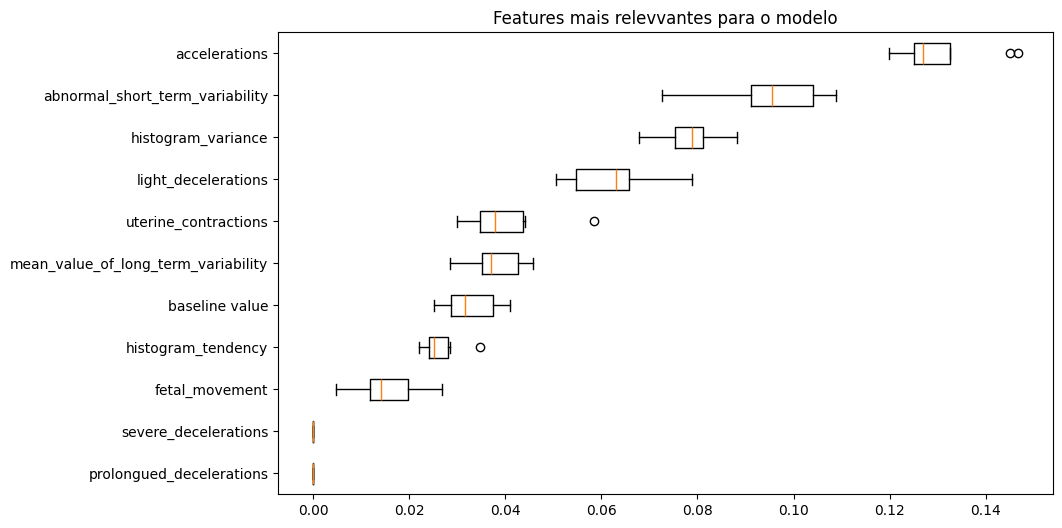

In [87]:
# Boxplot das features mais importantes
result = permutation_importance(
    mlp_bin,
    X_test,
    y_test,
    n_repeats=10,
    random_state=42,
    n_jobs=-1,
    )

sorted_idx = result.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
plt.title("Features mais relevvantes para o modelo")
plt.show()